In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import gan_helper
import sklearn.model_selection
import torch
import models
import util
import config
import viz
import os
import scipy.stats
GAN = gan_helper.Generator() # initializes gan
print('Done!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Done!


**note - look at some of the plots in `analyze_inn` nb to help with this**

# load latent-mapping model

In [46]:
orth_dict = pkl.load(open(oj(config.PROCESSED_DIR, '02_orth.pkl'), 'rb'))
orth_mat = orth_dict['vecs_orth'].transpose() # make it (512, 6)
offsets = np.array([a[0] for a in orth_dict['intercepts']]).flatten()

def predict(z, orth_mat, offsets):
    '''Return projection onto attribute space
    z is (batch_size, 512)
    '''
    return z @ orth_mat + offsets

def increase(z, orth_mat, attr_index, mult):
    '''Move in direction that increases attribute a
    '''
    z_alt = z + mult * orth_mat[:, attr_index].flatten()    
    print(np.around(z_alt @ orth_mat + offsets, 2))
    return z_alt


def even_bounds(z, attr_index, bounds=(-1, 1)):
    '''Generate z which varies
    '''

def normalize(u):
    return u / np.linalg.norm(u)


def projectToBoundary(X, planes, n_iter=100):
    n_planes = len(planes)

    if n_planes == 1:
        return project_to_plane(X, planes[0].coef_, planes[0].intercept_)

    # Iterative procedure for getting to boundary
    for i in range(n_iter):
        plane = planes[i % n_planes]
        X = project_to_plane(X, plane.coef_, plane.intercept_)

    return X 


def project_to_boundary(z, ws, bs, n_iter=100):
    '''
    Params
    ------
    X: np.ndarray (1, 512)
        point to be projected
    ws: np.ndarray (512, n_attributes)
        coefficients for different linear models
    bs: array_like (n_attributes)
        intercepts for linear model
    '''    
    n_attr = ws.shape[1]

    if n_attr == 1:
        return project_to_plane(z, ws[:, 0], bs[0])

    # Iterative procedure for getting to boundary
    for i in range(n_iter):
        attr_index = i % n_attr
        X = project_to_plane(z, ws[:, attr_index], bs[attr_index])

    return X   

def project_to_plane(z, w, b):
    '''
    Params
    ------
    X: np.ndarray (1, 512)
        point to be projected
    w: np.ndarray (512)
        coefficients for linear model
    b: scalar
        intercept for linear model
    '''
    
    w, b = w.copy(), b.copy()

    # Get and normalize coefficients
    b = b / np.linalg.norm(w)
    w = normalize(w)

    # Project points back to hyperplane, decision value = 0
    d = np.sum(w * z, -1) + b

    return z - w * np.expand_dims(d, 1)
    
# project the image to boundary
# z0 = np.random.randn(1, 512)
# z_new = project_to_boundary(z0, orth_mat, offsets, attr_index=0)

**let's walk in face space (using shared z)**

In [47]:
np.random.seed(3)
z0 = np.random.randn(1, 512) #zeros((1, 512)) #X[1:2] * 0
z0 = project_to_boundary(z0, orth_mat, offsets)
z0.shape

(1, 512)

[ 6.    1.76  0.39 -2.11 -0.32 -9.8 ]
[  4.     1.67   0.09  -1.38  -0.31 -10.2 ]
[  2.     1.58  -0.21  -0.65  -0.3  -10.6 ]
[ -0.     1.49  -0.52   0.08  -0.29 -11.  ]
[ -2.     1.4   -0.82   0.81  -0.28 -11.4 ]
[ -4.     1.3   -1.12   1.54  -0.27 -11.79]
[ -6.     1.21  -1.42   2.27  -0.26 -12.19]
(7, 512)


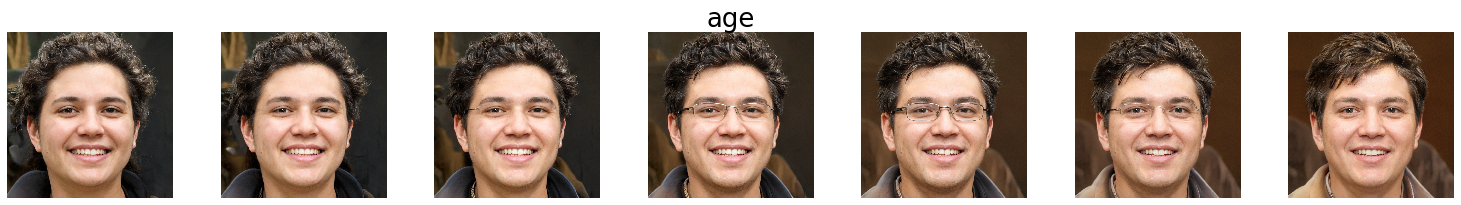

[  0.21   6.    -0.46  -0.37  -0.25 -10.45]
[  0.21   4.    -0.47  -0.2   -0.27 -10.68]
[  0.21   2.    -0.48  -0.04  -0.28 -10.9 ]
[  0.21  -0.    -0.49   0.12  -0.3  -11.13]
[  0.21  -2.    -0.5    0.28  -0.31 -11.35]
[  0.21  -4.    -0.51   0.45  -0.33 -11.57]
[  0.2   -6.    -0.52   0.61  -0.34 -11.8 ]
(7, 512)


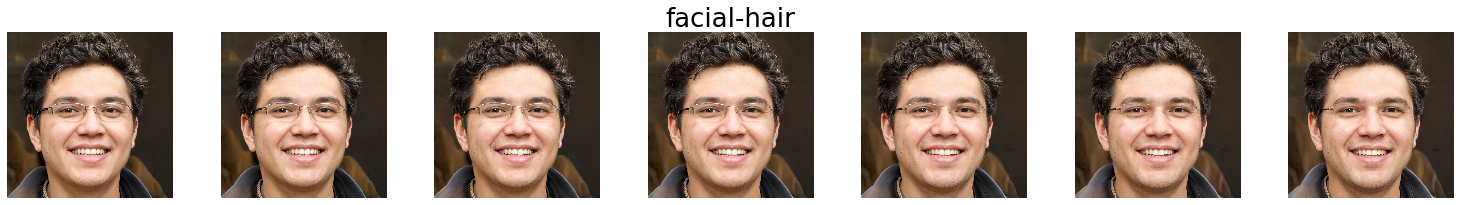

[  1.04   2.88   6.    -0.7   -0.37 -14.72]
[  0.79   2.46   4.    -0.48  -0.35 -13.56]
[  0.53   2.03   2.    -0.27  -0.32 -12.4 ]
[  0.27   1.6    0.    -0.05  -0.29 -11.24]
[  0.02   1.17  -2.     0.16  -0.27 -10.08]
[-0.24  0.75 -4.    0.38 -0.24 -8.92]
[-0.5   0.32 -6.    0.59 -0.22 -7.76]
(7, 512)


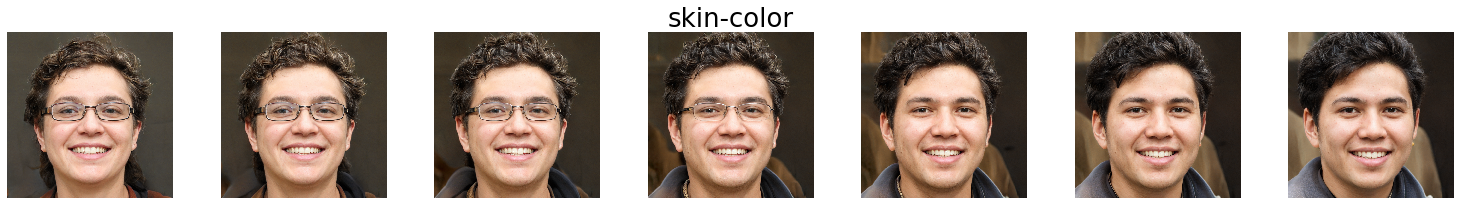

[ -0.32  -5.32  -0.67   6.    -0.81 -17.45]
[ -0.15  -3.05  -0.61   4.    -0.63 -15.29]
[  0.03  -0.78  -0.55   2.    -0.46 -13.12]
[  0.21   1.5   -0.48  -0.    -0.29 -10.96]
[ 0.39  3.77 -0.42 -2.   -0.12 -8.79]
[ 0.57  6.05 -0.36 -4.    0.06 -6.63]
[ 0.74  8.32 -0.3  -6.    0.23 -4.46]
(7, 512)


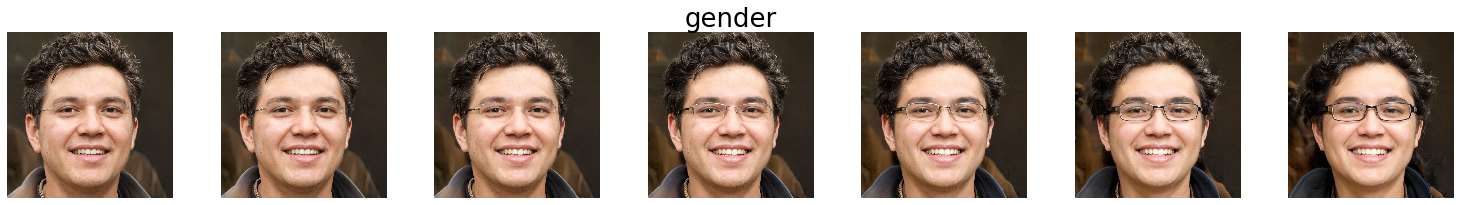

[ -0.28  41.55  -1.9  -32.99   6.    34.93]
[ -0.13  28.81  -1.45 -22.5    4.    20.34]
[  0.03  16.07  -1.   -12.01   2.     5.74]
[ 0.19  3.33 -0.55 -1.51 -0.   -8.85]
[  0.34  -9.4   -0.1    8.98  -2.   -23.45]
[  0.5  -22.14   0.35  19.47  -4.   -38.04]
[  0.66 -34.88   0.8   29.97  -6.   -52.64]
(7, 512)


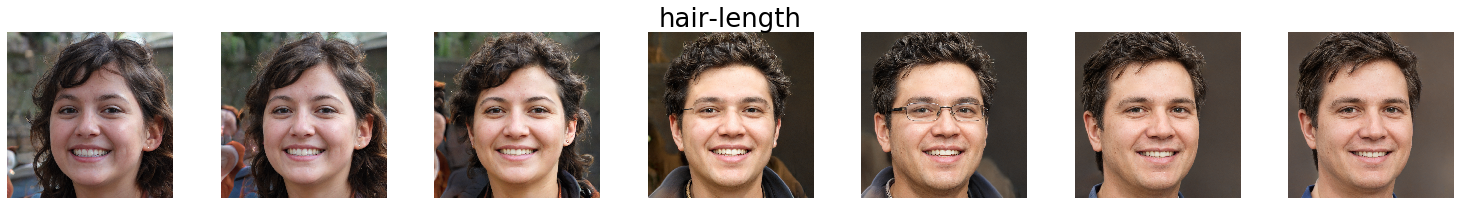

[ 0.27  3.29 -0.67 -1.24 -0.15  6.  ]
[ 0.26  3.08 -0.65 -1.09 -0.17  4.  ]
[ 0.25  2.87 -0.63 -0.94 -0.18  2.  ]
[ 0.25  2.66 -0.61 -0.8  -0.2   0.  ]
[ 0.24  2.44 -0.58 -0.65 -0.22 -2.  ]
[ 0.23  2.23 -0.56 -0.51 -0.23 -4.  ]
[ 0.23  2.02 -0.54 -0.36 -0.25 -6.  ]
(7, 512)


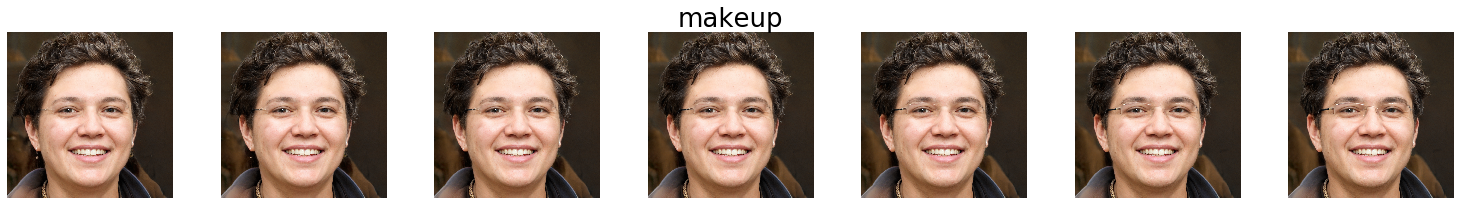

In [48]:
# # min/max to vary these attributes
# attr_bounds = { 
#     'age': (-2, 2),
#     'facial-hair': (-2, 2),
#     'skin-color': (-2, 2),
#     'gender': (-1, 1),
#     'hair-length': (-2, 2),
#     'makeup': (-2, 2)
# }
# min/max to vary these attributes
attr_mults = { 
    'age': 1,
    'facial-hair': 1,
    'skin-color': 1,
    'gender': 1,
    'hair-length': 1,
    'makeup': 0.5
}



# z0 = np.random.randn(1, 512) * 0.1
# z0 = project_to_boundary(z0, orth_mat, offsets)
N_IMS = 7 # should be odd

for attr_index, attr in enumerate(config.ATTRS):
#     z_new = project_to_plane(z0, orth_mat[:, attr_index], offsets[attr_index])
    zs = np.zeros((N_IMS, 512))
    mult = 0.1 * attr_mults[attr] # 1e0 #5e-4
    for j in range(N_IMS):
        diff = j - N_IMS // 2
        zs[j] = project_to_plane(z0, orth_mat[:, attr_index],
                                 offsets[attr_index] + diff * 2)
        print(np.around(zs[j] @ orth_mat + offsets, 2))
#         print(f'{zs[j] @ orth_mat[:, attr_index] + offsets[attr_index] + diff:0.2f}')
#         zs[j] = increase(z0, orth_mat, attr_index=attr_index, mult=diff * mult)
    images = GAN.gen(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()

# using projected images (full z)

**get a latent from embedding**

In [78]:
fnames = sorted([fname 
          for fname in os.listdir(config.REAL_LATENT_ENCODINGS_DIR)
          if '.npy' in fname])
latents = np.load(oj(config.REAL_LATENT_ENCODINGS_DIR, fnames[1]))
z0 = np.expand_dims(latents, 0)

In [ ]:
# print('z at different scales are not the same')
# viz.corrplot(np.corrcoef(latents))
# plt.colorbar()
# plt.show()

In [ ]:
# im = GAN.gen_full(z0)
# util.imshow(im)

**let's walk in face space**

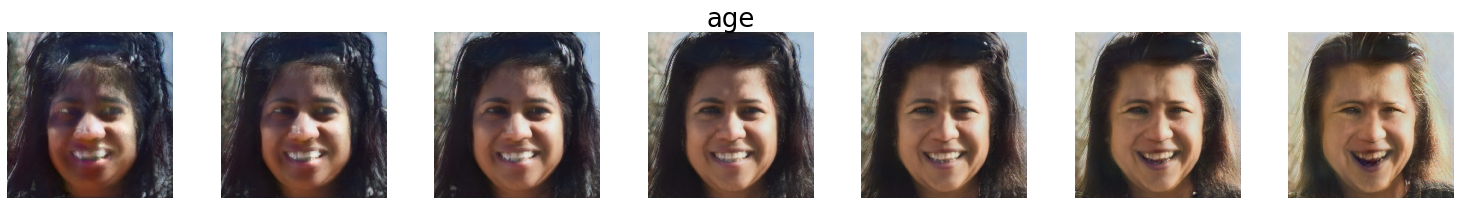

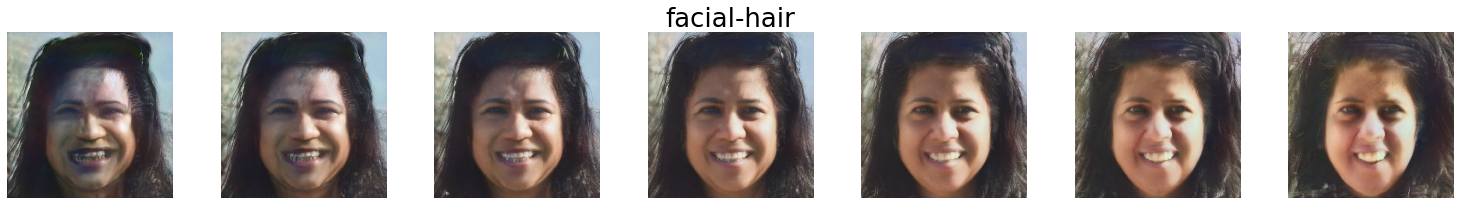

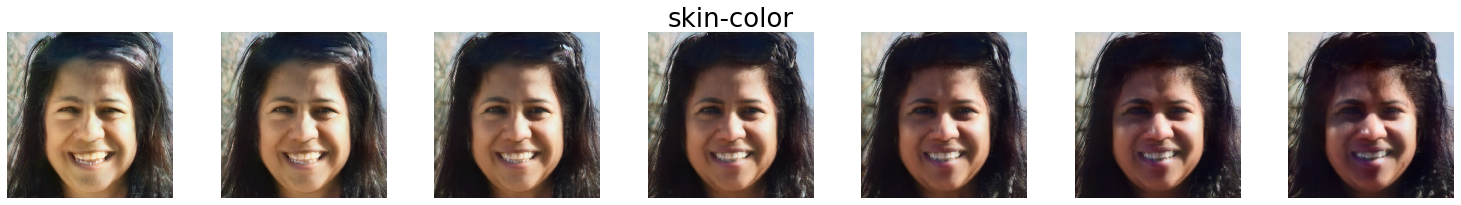

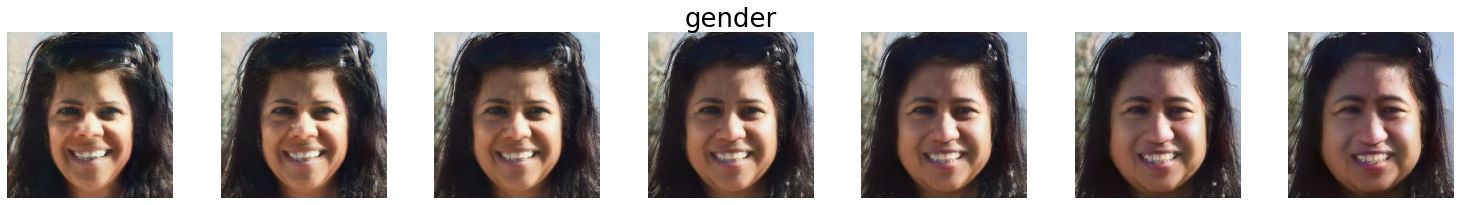

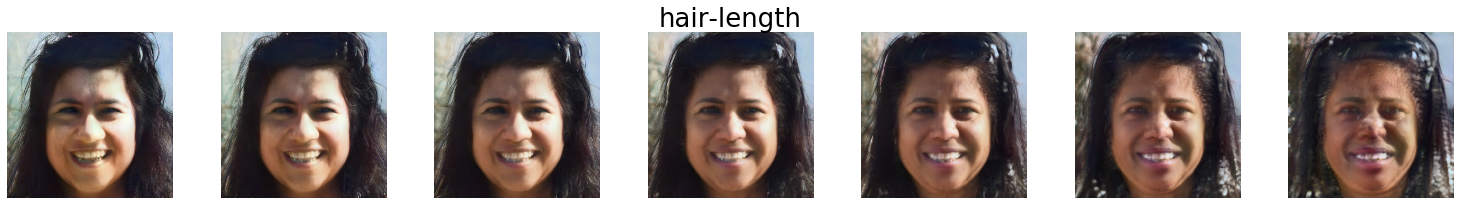

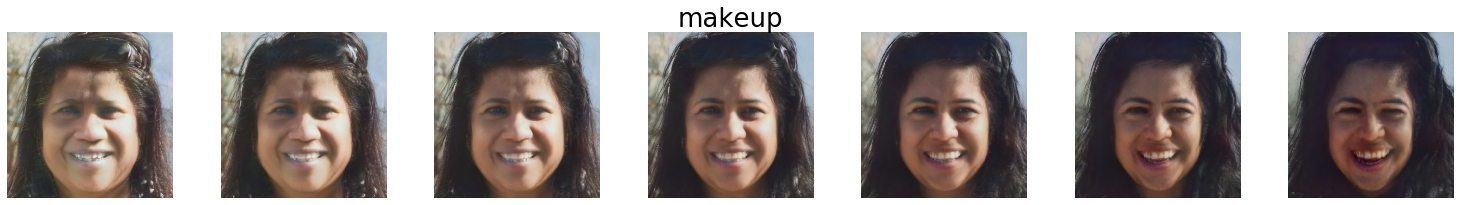

In [88]:
z0 = np.squeeze(z0)
# z0: (18, 512)
N_IMS = 7 # should be odd
MULT = 18
a = m(torch.Tensor(z0))
for attr_index, attr in enumerate(config.ATTRS):
    
    # get a mapping for z0
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 0.05
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
#         a_arr[j * MULT: j * MULT + 17, attr_index] += diff * mult * delta
        a_arr[j * MULT: (j + 1) * MULT, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    zs = zs.reshape(N_IMS, MULT, -1).squeeze()
    images = GAN.gen_full(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()